In [1]:
import imagej as setup
# Please fill in the blanks blow with correct path on your computer

# Fiji.app
# Example: /home/usr/Fiji.app
ij_dir = '/home/loci/code/Fiji.app'

# Conda Enviroment
# Example : /home/usr/anaconda3/envs/yourenvs/
Conda_env = '/home/loci/anaconda3/envs/cp-notebooks'
setup.setenv('CONDA_PREFIX', Conda_env)

# Java_Home
# Example: /home/usr/anaconda3/envs/yourenvs/
Java_Home = '/home/loci/anaconda3/envs/cp-notebooks'
setup.setenv('JAVA_HOME', Java_Home)

# If you are using Java 9, to solve the jre reconstruct problem
# Please make a simlink of jre folder in your java path
# Example: type "sudo ln -s . jre" into terminal at your java path

setup.quiet_init(ij_dir)

Conda environment: /home/loci/anaconda3/envs/cp-notebooks
PYJNIUS_JAR: /home/loci/anaconda3/envs/cp-notebooks/share/pyjnius/pyjnius.jar
Java environment: /home/loci/anaconda3/envs/cp-notebooks
Added 261 JARs to the Java classpath.


In [3]:
import json
import StringIO
import cellprofiler.image
import cellprofiler.measurement
import cellprofiler.object
import cellprofiler.pipeline
import cellprofiler.preferences
import cellprofiler.workspace
import imglyb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import jnius
from jnius import JavaException
import skimage.io

In [4]:
def run_pipeline(pipeline_filename, image_dict):
    cellprofiler.preferences.set_headless()
    
    # Create and load the pipeline
    pipeline = cellprofiler.pipeline.Pipeline()
    pipeline.load(pipeline_filename)
    
    # Create the image set, and add the image data
    image_set_list = cellprofiler.image.ImageSetList()
    image_set = image_set_list.get_image_set(0)
    for image_name, input_pixels in image_dict.iteritems():
        image_set.add(image_name, cellprofiler.image.Image(input_pixels))
        
    # Persist the object set here (for now, see workspace TODO)
    object_set = cellprofiler.object.ObjectSet()

    # We can only run one group -- set the group index to 1.
    measurements = cellprofiler.measurement.Measurements()
    measurements.group_index = 1

    # Run the modules!
    for module in pipeline.modules():
        # Yes, we really do have to create a new workspace for each module
        # because the module attribute is required. Go team.
        workspace = cellprofiler.workspace.Workspace(
            image_set=image_set,
            image_set_list=image_set_list,
            measurements=measurements, 
            module=module,
            object_set=object_set, 
            pipeline=pipeline
        )
        
        module.prepare_run(workspace)
        module.run(workspace)
        module.post_run(workspace)
    
    # The workspace object has access to the measurements
    # and the image set/image set list which can be used
    # to use/view/store/whatever output data.
    return workspace


def objects2df(measurements, objects_name):
    features = measurements.get_feature_names(objects_name)
    
    n_features = len(features)
    n_objects = int(measurements.get_measurement("Image", "Count_{}".format(objects_name)))
    
    data = np.empty((n_objects, n_features))
    
    for feature_idx, feature in enumerate(features):
        data[:, feature_idx] = measurements.get_measurement(objects_name, feature)
    
    return pd.DataFrame(
        data=data,
        index=np.arange(1, n_objects + 1),
        columns=features
    )


def data2image(data):
    return Image.open(StringIO.StringIO(data))


def show(image):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

In [5]:
# Spin up the ImageJ context.
ImageJ = jnius.autoclass('net.imagej.ImageJ')
ij = ImageJ()

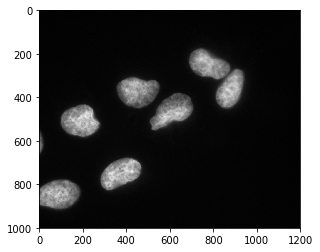

In [6]:
img = skimage.io.imread('data/images/1-162hrhoe2.tif')
show(img)

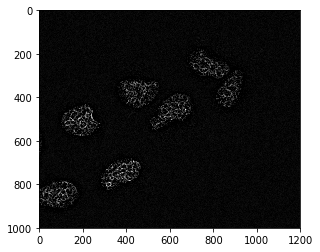

In [7]:
# Enhance edges using ImageJ's morphology.topHat op.

ArrayList = jnius.autoclass('java.util.ArrayList')
HyperSphereShape = jnius.autoclass('net.imglib2.algorithm.neighborhood.HyperSphereShape')
Views = jnius.autoclass('net.imglib2.view.Views')
TopHat = jnius.autoclass('net.imglib2.algorithm.morphology.TopHat')

enhanced = np.zeros(img.shape, dtype=img.dtype)
java_out = Views.iterable(imglyb.to_imglib(enhanced))
java_in = imglyb.to_imglib(img)
shapes = ArrayList()
shapes.add(HyperSphereShape(5))
try:
    #TopHat.topHat(java_in, java_out, HyperSphereShape(5), 1)
    ij.op().morphology().topHat(java_out, java_in, shapes)
except jnius.JavaException as exc:
    print("\n\tat ".join(exc.stacktrace))
show(enhanced)

In [9]:
images = {
    'EnhancedGreen': enhanced,
    'OrigBlue': skimage.io.imread('data/images/1-162hrhoe2.tif'),
    'OrigGreen': img
}

pipeline_filename = 'data/ExampleSpeckles.cppipe'

workspace = run_pipeline(pipeline_filename, images)

In [10]:
df = objects2df(workspace.measurements, "Nuclei")
df.head()

,Children_h2ax_Count,Intensity_IntegratedIntensityEdge_OrigBlue,Intensity_IntegratedIntensity_OrigBlue,Intensity_LowerQuartileIntensity_OrigBlue,Intensity_MADIntensity_OrigBlue,Intensity_MassDisplacement_OrigBlue,Intensity_MaxIntensityEdge_OrigBlue,Intensity_MaxIntensity_OrigBlue,Intensity_MeanIntensityEdge_OrigBlue,Intensity_MeanIntensity_OrigBlue,...,Mean_h2ax_Location_CenterMassIntensity_Y_OrigGreen,Mean_h2ax_Location_CenterMassIntensity_Z_OrigGreen,Mean_h2ax_Location_Center_X,Mean_h2ax_Location_Center_Y,Mean_h2ax_Location_Center_Z,Mean_h2ax_Location_MaxIntensity_X_OrigGreen,Mean_h2ax_Location_MaxIntensity_Y_OrigGreen,Mean_h2ax_Location_MaxIntensity_Z_OrigGreen,Mean_h2ax_Number_Object_Number,Number_Object_Number
1,24.0,6.313191,352.749708,0.017929,0.002747,0.787151,0.015625,0.031525,0.013845,0.020740,...,261.126875,0.0,777.150336,261.126750,0.0,777.750000,261.166667,0.0,12.500000,1.0
2,11.0,5.851698,343.493143,0.019028,0.003342,0.647997,0.015061,0.033371,0.013834,0.022287,...,374.294880,0.0,868.028038,374.303455,0.0,868.363636,374.000000,0.0,46.454545,2.0
3,29.0,7.736828,362.214925,0.016312,0.003342,3.141393,0.015808,0.031235,0.013742,0.019912,...,368.439598,0.0,455.739577,368.440130,0.0,455.862069,368.655172,0.0,44.034483,3.0
4,32.0,8.231449,374.368477,0.016419,0.003906,3.454832,0.015885,0.032914,0.013765,0.020390,...,469.717922,0.0,608.748773,469.712427,0.0,609.093750,470.156250,0.0,90.718750,4.0
5,51.0,6.446189,434.481806,0.019135,0.003494,3.068234,0.016205,0.033402,0.014075,0.022636,...,504.074241,0.0,193.973244,504.072514,0.0,193.921569,504.313725,0.0,115.431373,5.0


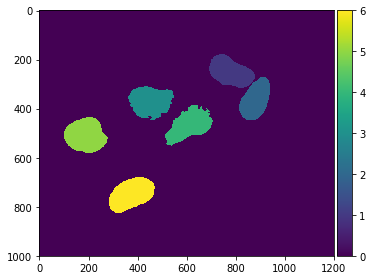

In [12]:
nuclei = workspace.object_set.get_objects("Nuclei")
skimage.io.imshow(nuclei.segmented)